# MNIST & Fashion MNIST
The MNIST dataset helps the data science practitioner understand the basics of classification systems, which is an example of *Supervised Learning*. The current set is called the "hello world" of *Machine Learning*. 

## Libraries & Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

#Modelling
from sklearn import svm
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Testing
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report

%matplotlib inline

## Common functions

In [2]:
def plot_images(images_data,labels_data):
    fig, axes = plt.subplots(1, 8,figsize=(14,2))
    images_and_labels = list(zip(images_data, labels_data))
    for ax, (image, label) in zip(axes, images_and_labels[:8]):
        image = image.reshape(28,28)
        ax.set_axis_off()
        ax.imshow(image, cmap='binary')
        ax.set_title('Training: %i' % label)

In [3]:
def plot_conf_mat(models,X,y,label):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    fig.suptitle(f'Confusion Matrix - {label}',fontsize=16)

    for model, ax in zip(models, axes.flatten()):
        estimator = models[str(model)]

        plot_confusion_matrix(estimator, 
                              X, 
                              y, 
                              ax=ax, 
                              cmap='Blues',
                              normalize= 'all',
                              values_format = '.2f',
                              display_labels=list(estimator.classes_))
        ax.title.set_text(type(estimator).__name__)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
    plt.show()

In [4]:
def classif_report(models,X_test,y_test):
    for model in models:

        estimator = models[str(model)]
        y_pred = models[str(model)].predict(X_test)
        report = classification_report(y_test,y_pred,
                                       output_dict=True,
                                       target_names=list(estimator.classes_))
        clsf_report = pd.DataFrame(report).transpose()
        print(model+ '\n' + str(clsf_report) + '\n')

In [5]:
def accuracy_score_models(models,X_test):
    for model in models:
        estimator = models[str(model)]
        y_pred = estimator.predict(X_test)
        print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),3))

In [6]:
def pr_roc_curves_multiclass(estimator,X,y,label = None):
    # Binarize the output
    y = label_binarize(y, classes=list(estimator.classes_))
    n_classes = y.shape[1]

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=0,
                                                        shuffle=True,stratify = y)

    # Learn to predict each class against the other
    y_score = estimator.decision_function(X_test)
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    #Compute Precision-Recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    
    # Compute micro-average ROC curve and ROC area and aggregate all false positive rates
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    # Average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,average="micro")


    
    # Setup plot details
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','darkviolet','gold','blue'])
    lw = 2

    # Plot Precision - Recall curves
    # Plot iso-F1 curves
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = ax[0].plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = ax[0].plot(recall["micro"], precision["micro"], linestyle=':', color='deeppink', lw=4)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'''.format(average_precision["micro"]))
    
    # Plot ROC Curves
    ax[1].plot(fpr["micro"], tpr["micro"],
             color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]))

    ax[1].plot(fpr["macro"], tpr["macro"],
             color='navy', linestyle=':', linewidth=4,
             label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]))

    
    for i, color in zip(range(n_classes), colors):
        class_ref = list(estimator.classes_)[i]
        # Plot Precision - Recall curves for each class
        l, = ax[0].plot(recall[i], precision[i], color=color, lw=lw)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'''.format(class_ref, average_precision[i]))
        
        # Same for ROC curves
        ax[1].plot(fpr[i], tpr[i], color=color, lw=lw,
                   label='ROC curve of class {0} (area = {1:0.2f})'''.format(class_ref,roc_auc[i]))

    
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.01])
    ax[0].set_xlabel('Recall',fontsize=12)
    ax[0].set_ylabel('Precision',fontsize=12)
    ax[0].set_title(f'Precision-Recall Curve - {type(estimator).__name__} {label}',fontsize=12)
    ax[0].legend(lines, labels, loc=(0, -.6), prop=dict(size=12),frameon = False,fontsize=12)
    
    ax[1].plot([0, 1], [0, 1], 'k--', lw=lw)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.01])
    ax[1].set_xlabel('False Positive Rate',fontsize=12)
    ax[1].set_ylabel('True Positive Rate',fontsize=12)
    ax[1].set_title(f'ROC Curve - {type(estimator).__name__} {label}',fontsize=12)
    ax[1].legend(loc=(0, -.65), prop=dict(size=12),frameon=False,fontsize=12)

    plt.show()

## MNIST
The MNIST dataset is composed by 70,000 labeled images, handwritten by high school students and employees of the US Central Bureau.

### Data Loading

In [7]:
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X,y = mnist['data'], mnist['target']
y.reshape(y.shape[0],1)
y = y.astype(np.uint8)
print(f'The dataset has {X.shape[0]} images of {X.shape[1]} pixels, e.g 28x28 images.')

The dataset has 70000 images of 784 pixels, e.g 28x28 images.


Some examples of the images are shown below.

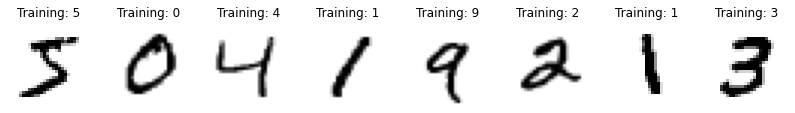

In [9]:
plot_images(X,y)

The balance of different classes in the dataset will be checked as follows.

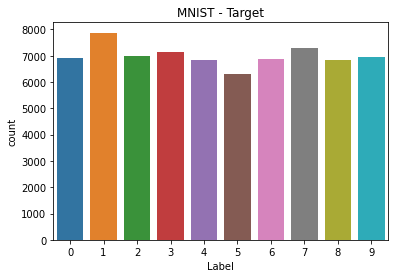

In [10]:
sns.countplot(y)
plt.title('MNIST - Target')
plt.xlabel('Label')
plt.show()

The dataset will be split into Train and Test sets, the Test set will correspond to the 20% of the total data.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

### Modelling
The following classifiers will be trained:  
- Logistic Regression Classifier
- Decision Tree Classifier

In [24]:
models ={}

In [25]:
tree = DecisionTreeClassifier(random_state = 0, criterion = "gini")
tree.fit(X_train,y_train)
models[str(type(tree).__name__)] = tree

In [26]:
logistic = LogisticRegression(solver = 'lbfgs', n_jobs=-1, max_iter=450, random_state=0)
logistic.fit(X_train, y_train)
models[str(type(logistic).__name__)] = logistic

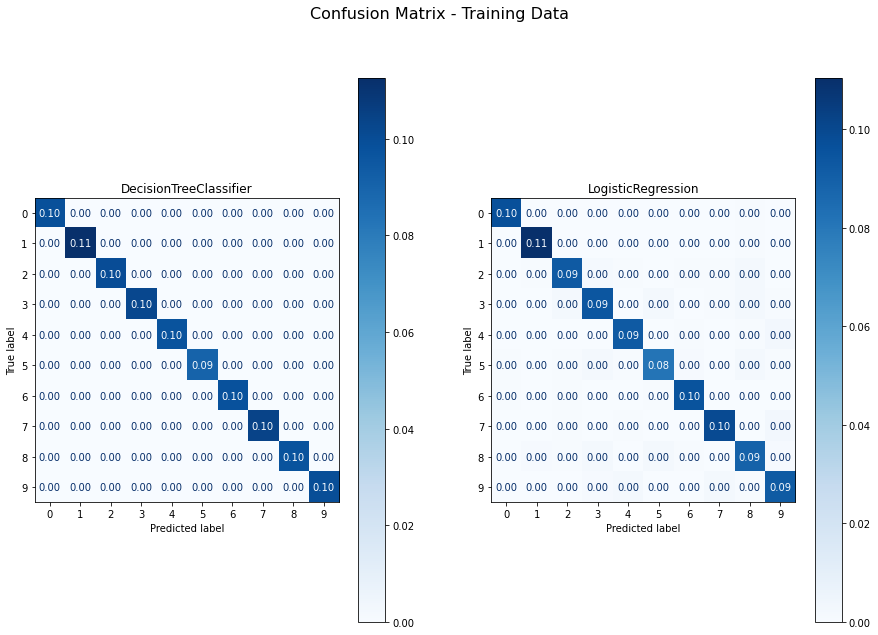

In [27]:
plot_conf_mat(models, X_train, y_train, label = 'Training Data')

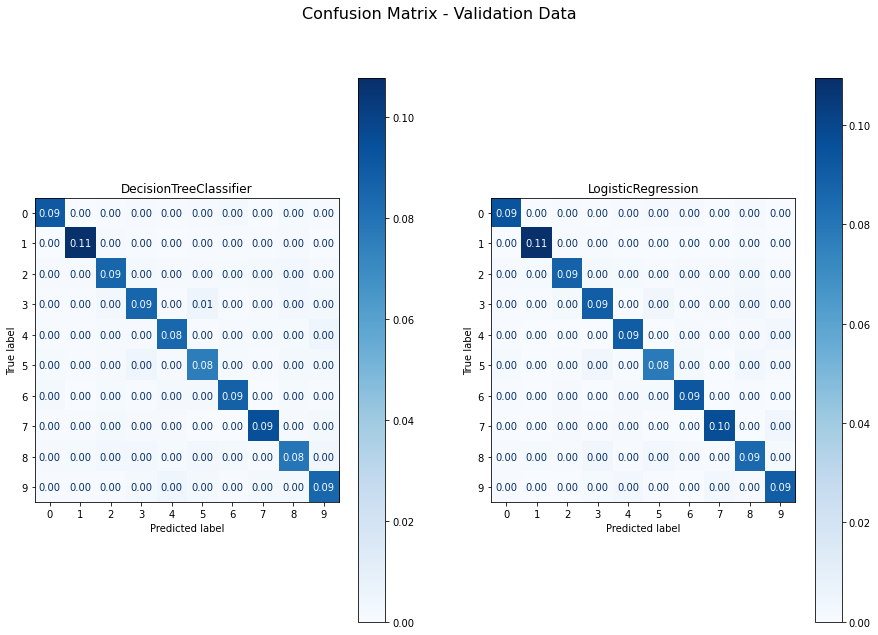

In [28]:
plot_conf_mat(models, X_test, y_test, label = 'Validation Data')

In [29]:
classif_report(models,X_test,y_test)

DecisionTreeClassifier
              precision    recall  f1-score    support
0              0.920785  0.918116  0.919448   1380.000
1              0.946014  0.956825  0.951389   1575.000
2              0.864260  0.856223  0.860223   1398.000
3              0.837291  0.839636  0.838462   1428.000
4              0.874631  0.868864  0.871738   1365.000
5              0.827856  0.837688  0.832743   1263.000
6              0.897134  0.888000  0.892544   1375.000
7              0.913402  0.910898  0.912148   1459.000
8              0.829580  0.809524  0.819429   1365.000
9              0.834497  0.858477  0.846317   1392.000
accuracy       0.876000  0.876000  0.876000      0.876
macro avg      0.874545  0.874425  0.874444  14000.000
weighted avg   0.876015  0.876000  0.875967  14000.000

LogisticRegression
              precision    recall  f1-score       support
0              0.946801  0.954348  0.950559   1380.000000
1              0.958073  0.972063  0.965017   1575.000000
2            

In [30]:
accuracy_score_models(models,X_test)

DecisionTreeClassifier 0.876
LogisticRegression 0.915


<ipython-input-6-df2946293caf>:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


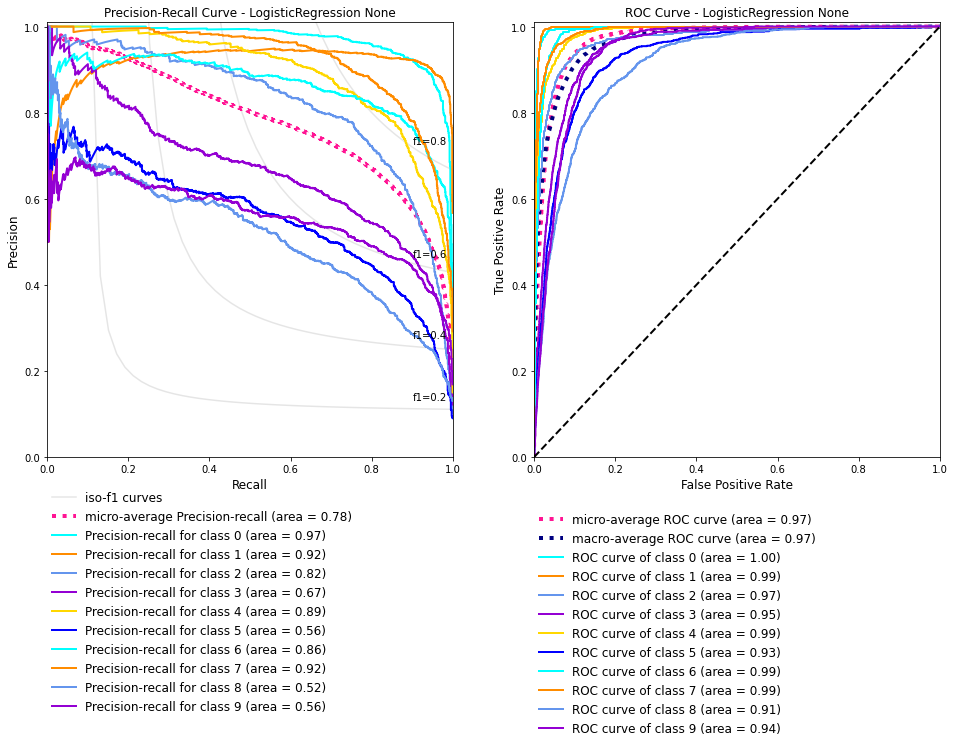

In [31]:
pr_roc_curves_multiclass(models['LogisticRegression'], X_train, y_train)

## Fashion MNIST
An approach to object classification.

### Data Loading

In [32]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

In [52]:
len(test_images)

10000

Some examples of the images are shown below.

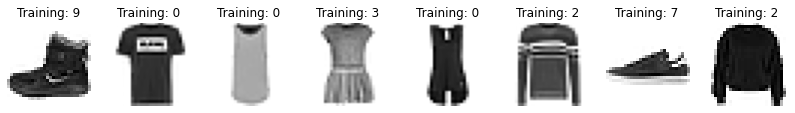

In [33]:
plot_images(train_images,train_labels)

The balance of different classes in the dataset will be checked as follows.

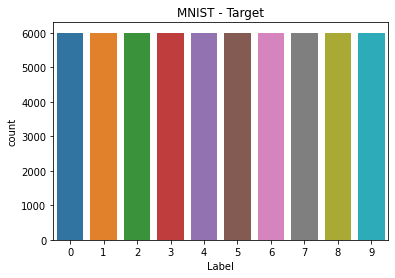

In [34]:
sns.countplot(train_labels)
plt.title('MNIST - Target')
plt.xlabel('Label')
plt.show()

The data will be normalized as follows.

In [38]:
train_images = train_images / 255.0
test_images =  test_images / 255.0

### Modelling

In [35]:
model = keras.Sequential([keras.layers.Flatten(input_shape = (28,28)),
                          keras.layers.Dense(128, activation=tf.nn.relu),
                          keras.layers.Dense(10, activation = tf.nn.softmax)])

In [44]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy')

In [48]:
model.fit(train_images, train_labels, epochs = 15)

Epoch 1/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2799
Epoch 2/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2668
Epoch 3/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2572
Epoch 4/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2463
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2386
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2313
Epoch 7/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2227
Epoch 8/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2150
Epoch 9/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2094
Epoch 10/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2014
Epoch 11/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1984
Epoch 12/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1934
E

In [49]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.3503


0.3502616584300995